In [1]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import json
import datetime
import random
import scipy.spatial as sp
from typing import List
import tensorflow_hub as hub
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from google.colab import drive

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

     |████████████████████████████████| 2.1MB 10.7MB/s 
     |████████████████████████████████| 901kB 50.0MB/s 
     |████████████████████████████████| 3.3MB 57.1MB/s 


In [2]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla P100-PCIE-16GB


**READ DATASET (DATASET -2)** Kaynak:

In [8]:
!unzip /content/drive/MyDrive/hesaplamalı_ödev_3/7allV03.csv.zip

Archive:  /content/drive/MyDrive/hesaplamalı_ödev_3/7allV03.csv.zip
  inflating: 7allV03.csv             


In [9]:
df = pd.read_csv('/content/7allV03.csv')

In [10]:
df.groupby('category').size()

category
dunya         700
ekonomi       700
kultur        700
saglik        700
siyaset       700
spor          700
teknoloji     700
dtype: int64

In [11]:
df['encoded_categories'] = LabelEncoder().fit_transform(df['category'])

In [12]:
df.groupby('encoded_categories').size()

encoded_categories
0    700
1    700
2    700
3    700
4    700
5    700
6    700
dtype: int64

In [13]:
# divide train and test
training = df.groupby('encoded_categories').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([df,training]).drop_duplicates(keep=False)

In [14]:
training_texts = training.text.values
training_labels = training.encoded_categories.values

In [15]:
test_texts = test.text.values
test_labels = test.encoded_categories.values

**UTILITY FUNCTIONS**

In [ ]:
def plot_histogram(data, x_label, y_label):
  BIGGER_SIZE: int = 16
  plt.figure(figsize=(8,8))
  plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
  plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
  plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
  plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
  plt.rc('figure', titlesize=BIGGER_SIZE)
  sns.set_style("darkgrid")
  p = sns.barplot(x=x_label, y=y_label, data=data)

**BERT**

In [16]:
# HyperParameters
class HyperParameters:
  max_len = 50
  batch_size = 32 # data loader batch size
  number_of_class = 7
  epochs = 4 # training epoch number
  lr = 5e-5 # optimizer learning rate
  eps = 1e-8 # optimizer eps
  seed_val = 1903

In [17]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=True)

In [18]:
model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = HyperParameters.number_of_class, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [19]:
def prepare_data_for_bert_classification(texts: List[str], labels: List[int]):
  """
  This method creates input_ids, attention_masks and labels  for BERT

  Parameters:
      texts: list of strings to get input masks
      labels: labels of the texts in type list of integers

  Returns:
      input_ids
      attention_masks
      labels
  """
  input_ids = []
  attention_masks = []
  for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = HyperParameters.max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
  
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  return input_ids, attention_masks, labels

In [20]:
def get_data_loader(input_ids, attention_masks, labels):
  dataset = TensorDataset(input_ids, attention_masks, labels)
  dataloader = DataLoader(
                          dataset,  
                          sampler = RandomSampler(dataset), 
                          batch_size = HyperParameters.batch_size 
                          )
  return dataloader


In [21]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
def fine_tune_BERT_for_classification(train_dataloader, model):
  # resource https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

  epochs = HyperParameters.epochs

  optimizer = AdamW(model.parameters(),
                  lr = HyperParameters.lr,
                  eps = HyperParameters.eps 
                )

  total_steps = len(train_dataloader) * HyperParameters.epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

  seed_val = HyperParameters.seed_val

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  training_stats = []
  total_t0 = time.time()

  for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()  
        SequenceClassifierOutput =  model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)      
        loss, logits = SequenceClassifierOutput.loss, SequenceClassifierOutput.logits

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )
  
  print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  return training_stats, model

In [23]:
def get_predictions(test_texts, test_labels, model):
  model.eval()

  predictions , true_labels = [], []

  input_ids, attention_masks, labels = prepare_data_for_bert_classification(test_texts, test_labels)
  prediction_data = TensorDataset(input_ids, attention_masks, labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=HyperParameters.batch_size)

  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    predictions.append(logits)
    true_labels.append(label_ids)


  return predictions, true_labels

In [24]:
class BERT:
  def __init__(self, model):
    self.predictions = None
    self.model = model

  def train(self, x, y):
     training_texts = x
     training_labels = y
     
     input_ids, attention_masks, labels = prepare_data_for_bert_classification(texts= training_texts, 
                                                                               labels= training_labels)
     train_dataloader = get_data_loader(input_ids=input_ids,
                                        attention_masks= attention_masks,
                                        labels= labels)
     
     training_stats, self.model = fine_tune_BERT_for_classification(train_dataloader=train_dataloader,
                                                                    model=self.model)

     return self

  def predict(self, x, y):
    self.predictions, true_labels = get_predictions(test_texts=test_texts,
                                                    test_labels= test_labels,
                                                    model=self.model)
    
    prediction_set = []
    for i in range(len(true_labels)):
      # here we get the index of max probability values for each sample in one batch
      pred_labels_i = np.argmax(self.predictions[i], axis=1).flatten()
      prediction_set.append(pred_labels_i)

    # for 32 batch we combine the predictions in one list
    prediction_scores = [item for sublist in prediction_set for item in sublist]
    return prediction_scores

  def predict_proba(self, x, y):
    predictions, true_labels = get_predictions(test_texts=x,
                                               test_labels= y,
                                               model=self.model)
    return np.array([item for sublist in predictions for item in sublist])

**TRAIN WITH ALL DATA**

In [25]:
bert = BERT(model=model)

In [26]:
scaler = MinMaxScaler() # initialize scaler to normalize probabilities

In [27]:
bert.train(training_texts, training_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.92
Training epoch took: 0:00:23
======== Epoch 2 / 4 ========
Average training loss: 0.24
Training epoch took: 0:00:23
======== Epoch 3 / 4 ========
Average training loss: 0.11
Training epoch took: 0:00:23
======== Epoch 4 / 4 ========
Average training loss: 0.05
Training epoch took: 0:00:22
Training completed in 0:01:30 (h:mm:ss)


In [28]:
prediction_scores = bert.predict(training_texts, training_labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [29]:
f1_score(test_labels, prediction_scores, average="macro")

0.9298072090799337

In [30]:
all_data_probabilities = bert.predict_proba(test_texts, test_labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [31]:
scaler.fit(all_data_probabilities)

MinMaxScaler(copy=True, feature_range=(0, 1))

**ACTIVE LEARNING**

In [32]:
training.info()
training.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3920 entries, (0, 1033) to (6, 4849)
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   category            3920 non-null   object
 1   text                3920 non-null   object
 2   encoded_categories  3920 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 294.1+ KB


In [33]:
test.info()
test.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 853 entries, 1 to 4898
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   category            853 non-null    object
 1   text                853 non-null    object
 2   encoded_categories  853 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 26.7+ KB


In [34]:
label_counts = (training['category']
                .value_counts(normalize=True)
                .rename('percentage')
                .mul(100)
                .reset_index()
                .rename(columns = {"index":"label"})
                )

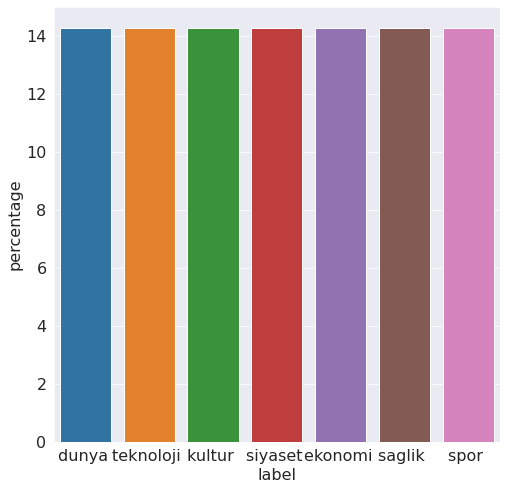

In [ ]:
plot_histogram(label_counts, "label", "percentage")

In [35]:
# First create initial train samples
initial_train = training.sample(frac=0.0254, random_state=42)
initial_train.reset_index(drop=True, inplace=True)
initial_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   category            100 non-null    object
 1   text                100 non-null    object
 2   encoded_categories  100 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


In [ ]:
initial_train.head()

,category,text,encoded_categories
0,ekonomi,hollywood  a rakip stüdyo kuruluyor mars_ent...,1
1,kultur,bridget aşkı internette arıyor ilerleyen yaşı...,2
2,spor,2013 eurobasket in maskotu açıklandı slovenya...,5
3,teknoloji,skype geçmişinizi silin ! microsoft kullanıcı...,6
4,saglik,çocuklarınızla ve eşlerinizle çok ilgilenin k...,3


In [ ]:
initial_train.groupby('encoded_categories').size()

encoded_categories
0    15
1    18
2    15
3    15
4    11
5    12
6    14
dtype: int64

In [36]:
# then create unlabeled data pool
pool = training[~training.index.isin(initial_train.index)]
pool.reset_index(drop=True, inplace=True)

In [ ]:
pool.head()

,category,text,encoded_categories
0,dunya,türkiye nin yerini mısır aldı bbc türkiye nin...,0
1,dunya,türk israil ilişkileri sınanıyor new_york tim...,0
2,dunya,şehitlikte çekilen bu fotoğraf işinden etti a...,0
3,dunya,lübnan da çatışmalar 3 ölü lübnan ın başkenti...,0
4,dunya,yahudilerin torunlarına vatandaşlık hakkı isp...,0


In [37]:
# sample selection class
class SampleSelection:
  def __init__(self):
    self.scaler = scaler # normalizer to scale probas 0-1

  @staticmethod
  def random_selection(unlabeled_data: np.ndarray, num_samples: int) -> List[int]:
    """
    Random selection from unlabeled data pool

    Parameters:
      num_samples: how much samples we will label in one iteration
      unlabeled_data: samples in unlabeled pool

    Returns:
    List of data samples indexes from unlabeled dataset
    """
    if unlabeled_data.shape[0] >= num_samples:
      selection = np.random.choice(unlabeled_data.shape[0], num_samples, replace=False) # randomly choice indexes 
    else:
      selection = np.arange(unlabeled_data.shape[0])
    return selection

  def get_hard_samples(self, class_probas: np.ndarray, num_samples:int) -> List[int]:
    """
    This method takes hard sample indexes from unlabeled data pool

    hard-> probability of two class is similar (diffirence is small)

    Parameters:
      class_probas: probabilities for each class for all samples
      num_samples: how much samples we will label in one iteration

    Returns:
    List of data samples indexes from unlabeled dataset   
    """
    class_probas_scaled = self.scaler.transform(class_probas) 
    differences = np.std(class_probas_scaled, axis=1) # get the varyans for each proba

    if len(class_probas_scaled) >= num_samples:
      selection = np.argsort(differences)[:num_samples] # take the sample indexes which proba for two class is very close
    else:
      selection = np.argsort(differences)
    
    return selection

In [38]:
class BertActiveLearner:
  def __init__(self, test: pd.DataFrame,
               initial_train: pd.DataFrame,
               pool: pd.DataFrame,
               batch_size: int,
               label_col_name,
               text_col_name):
    self.batch_size = batch_size # number of samples to add train data in each iteration
    self.test = test
    self.train = initial_train.copy()
    self.pool = pool.copy()
    self.text_col_name = text_col_name
    self.label_col_name = label_col_name
    self.calculated_metrics = list()
    self.classifier = BERT(model=model)
    self.classifier.train(x=self.train[text_col_name].values, y=self.train[label_col_name].values)
    prediction_scores = self.classifier.predict(x=self.test[text_col_name].values,
                                                y=self.test[label_col_name].values)
    self.calculated_metrics.append(f1_score(self.test[label_col_name].values, prediction_scores, average="macro"))
    
  def active_learning(self, num_iteration: int, sampling_method):
    for i in range(num_iteration):
      print(f"################### ITERATION: {i + 1} ###################")
      probs = self.classifier.predict_proba(x=self.pool[self.text_col_name].values, y=self.pool[self.label_col_name].values)

      indexes = sampling_method(probs, self.batch_size) # get the indexes of data samples
  
      new = self.pool[self.pool.index.isin(indexes)] # select data samples by indexes from pool
      self.train = pd.concat([self.train, new]) # as we already have labels, append labelled sample to train data
      self.train.reset_index(drop=True, inplace=True)
      self.pool.drop(indexes, inplace=True) # drop selected samples from ublabeled pool
      self.pool.reset_index(drop=True, inplace=True) # reset indexing
      self.classifier = BERT(model=model)
      self.classifier.train(self.train[self.text_col_name].values, self.train[self.label_col_name].values)
      prediction_scores = self.classifier.predict(x=self.test[self.text_col_name].values,
                                                  y=self.test[self.label_col_name].values)
      self.calculated_metrics.append(f1_score(self.test[self.label_col_name].values, prediction_scores, average="macro"))
      print(self.calculated_metrics)

In [39]:
iterations_num = int(pool.shape[0]/100)
#iterations_num = 100
batch_size = 100

In [40]:
iterations_num

38

In [41]:
# random sampling
random_cycle = BertActiveLearner(test=test, 
                             initial_train=initial_train, 
                             pool=pool, 
                             batch_size=batch_size,
                             label_col_name="encoded_categories",
                             text_col_name="text")

random_cycle.active_learning(num_iteration = iterations_num,
                             sampling_method=SampleSelection().random_selection)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.03
Training epoch took: 0:00:01
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:01
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:01
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:01
Training completed in 0:00:02 (h:mm:ss)
################### ITERATION: 1 ###################
======== Epoch 1 / 4 ========
Average training loss: 0.03
Training epoch took: 0:00:01
======== Epoch 2 / 4 ========
Average training loss: 0.03
Training epoch took: 0:00:01
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:01
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:01
Training completed in 0:00:05 (h:mm:ss)
[0.9213164589865188, 0.9267204802273211]
################### ITERATION: 2 ###################
======== Epoch 1 / 4 ========
Average training loss: 0.04
Training epoch took

In [ ]:
# hard sampling
hard_cycle = BertActiveLearner(test=test, 
                           initial_train=initial_train, 
                           pool=pool, 
                           batch_size=batch_size,
                           label_col_name="encoded_categories",
                           text_col_name="text")

hard_cycle.active_learning(num_iteration = iterations_num,
                           sampling_method=SampleSelection().get_hard_samples)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:01
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:01
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:01
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:01
Training completed in 0:00:02 (h:mm:ss)
################### ITERATION: 1 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.04
Training epoch took: 0:00:01
======== Epoch 2 / 4 ========
Average training loss: 0.01
Training epoch took: 0:00:01
======== Epoch 3 / 4 ========
Average training loss: 0.01
Training epoch took: 0:00:01
======== Epoch 4 / 4 ========
Average training loss: 0.01
Training epoch took: 0:00:01
Training completed in 0:00:05 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408]
################### ITERATION: 2 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.11
Training epoch took: 0:00:02
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:02
======== Epoch 3 / 4 ========
Average training loss: 0.01
Training epoch took: 0:00:02
======== Epoch 4 / 4 ========
Average training loss: 0.01
Training epoch took: 0:00:02
Training completed in 0:00:07 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028]
################### ITERATION: 3 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.03
Training epoch took: 0:00:02
======== Epoch 2 / 4 ========
Average training loss: 0.01
Training epoch took: 0:00:02
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:02
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:02
Training completed in 0:00:09 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469]
################### ITERATION: 4 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:03
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:03
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:03
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:03
Training completed in 0:00:11 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829]
################### ITERATION: 5 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:03
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:03
======== Epoch 3 / 4 ========
Average training loss: 0.02
Training epoch took: 0:00:03
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:03
Training completed in 0:00:14 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224]
################### ITERATION: 6 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:04
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:04
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:04
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:04
Training completed in 0:00:16 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556]
################### ITERATION: 7 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:05
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:05
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:04
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:05
Training completed in 0:00:18 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953]
################### ITERATION: 8 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:05
======== Epoch 2 / 4 ========
Average training loss: 0.01
Training epoch took: 0:00:05
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:05
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:05
Training completed in 0:00:20 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846]
################### ITERATION: 9 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:06
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:06
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:06
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:06
Training completed in 0:00:23 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149]
################### ITERATION: 10 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:06
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:06
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:06
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:06
Training completed in 0:00:25 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948]
################### ITERATION: 11 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:07
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:07
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:07
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:07
Training completed in 0:00:27 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948, 0.9142645872329248]
################### ITERATION: 12 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:07
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:07
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:07
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:07
Training completed in 0:00:29 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948, 0.9142645872329248, 0.9184200758793055]
################### ITERATION: 13 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:08
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:08
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:08
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:08
Training completed in 0:00:32 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948, 0.9142645872329248, 0.9184200758793055, 0.917066968180843]
################### ITERATION: 14 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:08
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:08
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:08
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:08
Training completed in 0:00:34 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948, 0.9142645872329248, 0.9184200758793055, 0.917066968180843, 0.9129446552792526]
################### ITERATION: 15 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:09
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:09
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:09
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:09
Training completed in 0:00:36 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948, 0.9142645872329248, 0.9184200758793055, 0.917066968180843, 0.9129446552792526, 0.9129294628876957]
################### ITERATION: 16 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:10
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:10
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:10
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:10
Training completed in 0:00:38 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948, 0.9142645872329248, 0.9184200758793055, 0.917066968180843, 0.9129446552792526, 0.9129294628876957, 0.9027855777460972]
################### ITERATION: 17 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:10
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:10
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:10
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:10
Training completed in 0:00:41 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948, 0.9142645872329248, 0.9184200758793055, 0.917066968180843, 0.9129446552792526, 0.9129294628876957, 0.9027855777460972, 0.9105729161042465]
################### ITERATION: 18 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.01
Training epoch took: 0:00:11
======== Epoch 2 / 4 ========
Average training loss: 0.01
Training epoch took: 0:00:11
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:11
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:11
Training completed in 0:00:43 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948, 0.9142645872329248, 0.9184200758793055, 0.917066968180843, 0.9129446552792526, 0.9129294628876957, 0.9027855777460972, 0.9105729161042465, 0.9142996968991258]
################### ITERATION: 19 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:11
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:11
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:11
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:11
Training completed in 0:00:45 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948, 0.9142645872329248, 0.9184200758793055, 0.917066968180843, 0.9129446552792526, 0.9129294628876957, 0.9027855777460972, 0.9105729161042465, 0.9142996968991258, 0.9124282891606122]
################### ITERATION: 20 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:12
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:12
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:12
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:12
Training completed in 0:00:47 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948, 0.9142645872329248, 0.9184200758793055, 0.917066968180843, 0.9129446552792526, 0.9129294628876957, 0.9027855777460972, 0.9105729161042465, 0.9142996968991258, 0.9124282891606122, 0.9102960760916845]
################### ITERATION: 21 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:12
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:12
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:12
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:12
Training completed in 0:00:50 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948, 0.9142645872329248, 0.9184200758793055, 0.917066968180843, 0.9129446552792526, 0.9129294628876957, 0.9027855777460972, 0.9105729161042465, 0.9142996968991258, 0.9124282891606122, 0.9102960760916845, 0.9114457323921724]
################### ITERATION: 22 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:13
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:13
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:13
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:13
Training completed in 0:00:52 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948, 0.9142645872329248, 0.9184200758793055, 0.917066968180843, 0.9129446552792526, 0.9129294628876957, 0.9027855777460972, 0.9105729161042465, 0.9142996968991258, 0.9124282891606122, 0.9102960760916845, 0.9114457323921724, 0.9114995942401657]
################### ITERATION: 23 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:14
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:14
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:14
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:14
Training completed in 0:00:54 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948, 0.9142645872329248, 0.9184200758793055, 0.917066968180843, 0.9129446552792526, 0.9129294628876957, 0.9027855777460972, 0.9105729161042465, 0.9142996968991258, 0.9124282891606122, 0.9102960760916845, 0.9114457323921724, 0.9114995942401657, 0.9079553372348546]
################### ITERATION: 24 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:14
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:14
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:14
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:14
Training completed in 0:00:56 (h:mm:ss)
[0.9142290187306935, 0.8940290467039408, 0.916639229670028, 0.9127326805142469, 0.9128348599558829, 0.9065177069381224, 0.9092462669207556, 0.9125506377788953, 0.9163778114826846, 0.9153290648593149, 0.9153989779530948, 0.9142645872329248, 0.9184200758793055, 0.917066968180843, 0.9129446552792526, 0.9129294628876957, 0.9027855777460972, 0.9105729161042465, 0.9142996968991258, 0.9124282891606122, 0.9102960760916845, 0.9114457323921724, 0.9114995942401657, 0.9079553372348546, 0.9070687728643646]
################### ITERATION: 25 ###################


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


======== Epoch 1 / 4 ========


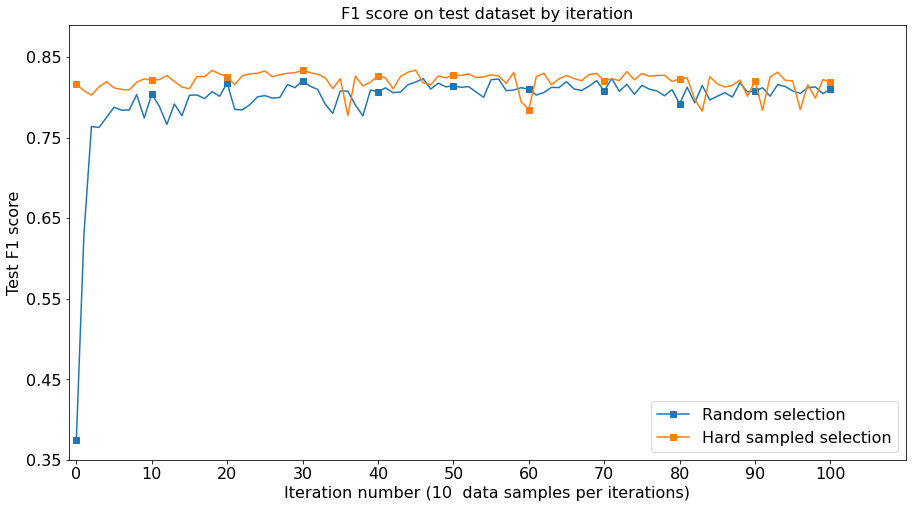

In [ ]:
import matplotlib.pyplot as plt

BIGGER_SIZE: int = 16
plt.figure(figsize=(15,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

iterations = np.arange(0, iterations_num+1, 1)

plt.title ("F1 score on test dataset by iteration", fontsize=BIGGER_SIZE)
plt.ylabel("Test F1 score", fontsize=BIGGER_SIZE)
plt.ylim(0.9,1.1)
plt.xlim(-1,iterations_num+10)
plt.xticks(np.arange(0, iterations_num+1, 10))
plt.yticks(np.arange(0.9,1.1,0.1))
plt.xlabel("Iteration number (100  data samples per iterations)")
plt.plot(iterations, random_cycle.calculated_metrics, label = "Random selection", marker='s', markevery=10)
plt.plot(iterations, hard_cycle.calculated_metrics, label = "Hard sampled selection", marker='s', markevery=10)
plt.legend()
plt.show()